## Imports required Library


In [1]:
# Imports
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

## Setting up the environment and Ploting settings

In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


set_seed(31415)

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")  # to clean up output cells

## Explore the Example Data

In [3]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[160, 160],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[160, 160],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 5117 files belonging to 2 classes.


2022-08-05 22:21:07.690935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:21:07.854570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:21:07.855424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 22:21:07.862182: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 5051 files belonging to 2 classes.


## Visualizing the Data

In [4]:
class_names = ds_train_.class_names
print(class_names)

['Car', 'Truck']


2022-08-05 22:21:12.815789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


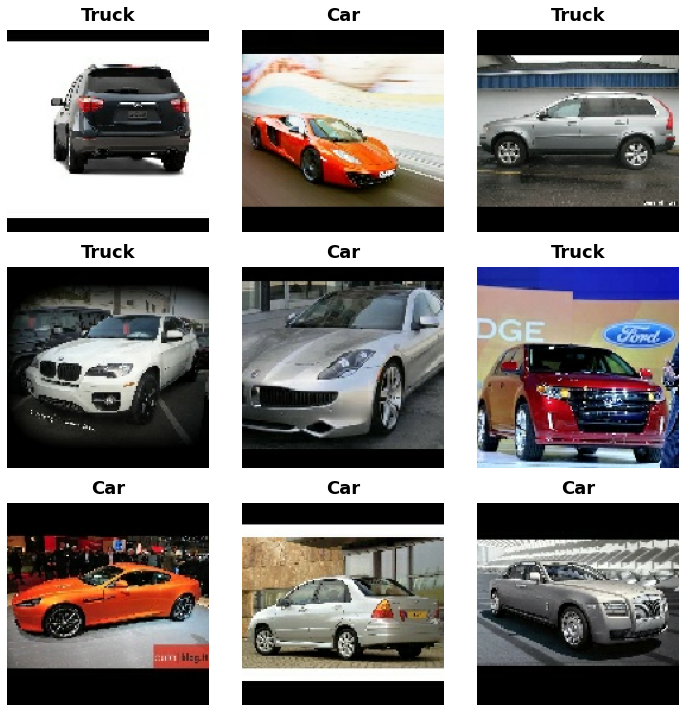

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train_.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().astype(int)[0]])
        plt.axis("off")

## Setting Data Pipeline

In [6]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
)


## Downloading the VGG16 pretrained model 

In [7]:
# Create the base model from the pre-trained model MobileNet V2
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

IMG_SHAPE = IMG_SIZE + (3,)

pretrained_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE)
pretrained_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
pretrained_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Creating the final Model from pre-trained model and Preprocessing layers

In [9]:
model = keras.Sequential([
    # Preprocessing
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
    # Base
    pretrained_base,
    # Head
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),

])

In [10]:
model.build(input_shape = (None,160,160,3))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 160, 160, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 160, 160, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 512)         3584      
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          294976    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

## Training

In [13]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=40,
    verbose=2,
)

Epoch 1/40


2022-08-05 22:21:21.176687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


80/80 - 47s - loss: 0.6920 - binary_accuracy: 0.5364 - val_loss: 0.6886 - val_binary_accuracy: 0.5781
Epoch 2/40
80/80 - 13s - loss: 0.6762 - binary_accuracy: 0.6066 - val_loss: 0.6118 - val_binary_accuracy: 0.6854
Epoch 3/40
80/80 - 13s - loss: 0.5153 - binary_accuracy: 0.7536 - val_loss: 0.4101 - val_binary_accuracy: 0.8139
Epoch 4/40
80/80 - 13s - loss: 0.4027 - binary_accuracy: 0.8147 - val_loss: 0.3981 - val_binary_accuracy: 0.8062
Epoch 5/40
80/80 - 13s - loss: 0.3680 - binary_accuracy: 0.8390 - val_loss: 0.3542 - val_binary_accuracy: 0.8450
Epoch 6/40
80/80 - 13s - loss: 0.3309 - binary_accuracy: 0.8562 - val_loss: 0.3509 - val_binary_accuracy: 0.8527
Epoch 7/40
80/80 - 13s - loss: 0.3008 - binary_accuracy: 0.8771 - val_loss: 0.3280 - val_binary_accuracy: 0.8586
Epoch 8/40
80/80 - 13s - loss: 0.2755 - binary_accuracy: 0.8808 - val_loss: 0.3377 - val_binary_accuracy: 0.8531
Epoch 9/40
80/80 - 13s - loss: 0.2599 - binary_accuracy: 0.8886 - val_loss: 0.3385 - val_binary_accuracy: 0

## Evaluating Accuracy and Loss for the Model


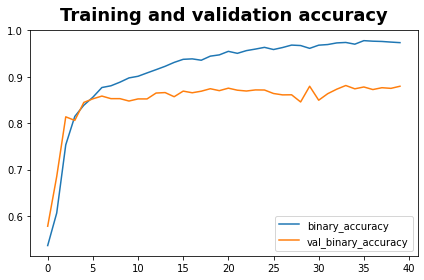

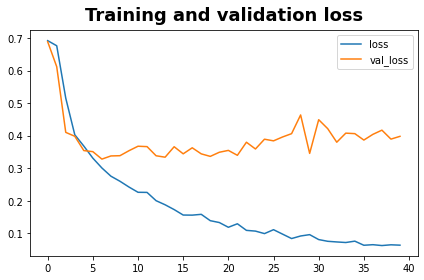

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'binary_accuracy' ]
val_acc  = history.history[ 'val_binary_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.legend(['binary_accuracy', 'val_binary_accuracy'])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )
plt.legend(['loss', 'val_loss'])
